In [1]:
import os
import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from collections import defaultdict
from pathlib import Path

import plotly.figure_factory as ff
import plotly.io as pio

import sklearn
from sklearn import set_config
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, f1_score
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc, RocCurveDisplay, precision_recall_curve, PrecisionRecallDisplay
from sklearn.multiclass import OneVsRestClassifier
# from sklearn.metrics import plot_confusion_matrix
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import make_pipeline
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import StandardScaler, FunctionTransformer, MinMaxScaler, MaxAbsScaler
from sklearn.linear_model import SGDClassifier, LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.compose import make_column_transformer
from sklearn.model_selection import learning_curve
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import average_precision_score, precision_recall_curve

import spacy
from spacy.lang.en import STOP_WORDS

import seaborn as sns

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
nli_train = pd.read_csv('TOEFL-train-tagged-readability.csv')
nli_test = pd.read_csv('TOEFL-test-tagged-readability.csv')

icle = pd.read_csv('icle_toefl_tagged_readability.csv')

In [4]:
# Concatenate the DataFrames along rows (axis=0)
toefl = pd.concat([nli_train, nli_test], axis=0)

# Reset the index of the merged DataFrame
toefl.reset_index(drop=True, inplace=True)

# Save the merged DataFrame to a new CSV file
toefl.to_csv('toefl.csv', index=False)

In [5]:
toefl.head()

,Unnamed: 0,Filename,text,Language,Proficiency,pos,readability_words,readability_sents
0,0,88.txt,Some people might think that traveling in a gr...,KOR,high,DET NOUN AUX VERB SCONJ VERB ADP DET NOUN VERB...,3.695962,23.388889
1,1,278.txt,IThe importance and popularity of travelling i...,DEU,medium,DET NOUN CCONJ NOUN ADP VERB AUX ADV VERB PUNC...,3.829480,23.066667
2,2,348.txt,"It is an important decision, how to plan your ...",TUR,high,PRON AUX DET ADJ NOUN PUNCT SCONJ PART VERB PR...,4.126551,25.187500
3,3,666.txt,Some people believe that young people can enjo...,ZHO,medium,DET NOUN VERB SCONJ ADJ NOUN AUX VERB NOUN ADJ...,3.812808,15.037037
4,4,733.txt,Travelling is usually considered as good recr...,TEL,medium,NOUN AUX SPACE ADV VERB ADP ADJ NOUN SPACE ADP...,4.072581,26.571429


In [6]:
icle.head()

,Unnamed: 0,Unnamed: 0.1,File_name,Native_language,Country,Gender,Age,1st_FL,2nd_FL,3rd_FL,...,Length_in_words,Type,Conditions,Reference_tools,Examination,Comments,Text,pos,readability_words,readability_sents
0,0,0,FRUC2027,FRA,Belgium,Female,21.0,Dutch,NaN,NaN,...,896,Literary,Timed,Yes,Yes,-,Different ways of managing kinds of wastes ar...,SPACE ADJ NOUN ADP VERB NOUN ADP NOUN AUX VERB...,4.380634,20.655172
1,1,1,FRUC2028,FRA,Belgium,Female,20.0,NaN,NaN,NaN,...,657,Literary,Timed,Yes,Yes,-,"Nowadays, people around the world pay more at...",SPACE ADV PUNCT NOUN ADP DET NOUN VERB ADJ NOU...,4.502755,22.000000
2,2,2,FRUC2029,FRA,Belgium,Female,22.0,German,Dutch,NaN,...,712,Literary,Timed,Yes,Yes,-,There are a million of trush produced by Hong...,SPACE PRON VERB DET NUM ADP NOUN VERB ADP PROP...,4.303290,16.642857
3,3,3,FRUC2030,FRA,Belgium,Female,21.0,Dutch,NaN,NaN,...,652,Literary,Timed,Yes,Yes,-,"In Hong Kong, majority of waste management is...",SPACE ADP PROPN PROPN PUNCT NOUN ADP NOUN NOUN...,4.421898,20.147059
4,4,4,FRUC2032,FRA,Belgium,Female,20.0,Dutch,NaN,NaN,...,1870,Literary,Timed,Yes,Yes,-,There are various way for treating waste mate...,SPACE PRON VERB ADJ NOUN ADP VERB NOUN NOUN AD...,4.519525,18.406250


In [5]:
desired_languages = ['JPN', 'DEU', 'KOR', 'ZHO', 'SPA', 'TUR', 'ITA', 'FRA']
toefl = toefl[toefl['Language'].isin(desired_languages)]

In [6]:
toefl.text.replace(r'\n+',' ', regex=True, inplace=True)
icle.Text.replace(r'\n+', ' ', regex=True, inplace=True)

In [7]:
X_toefl = toefl.drop(columns=['Unnamed: 0', 'Filename', 'Language', 'Proficiency'])
y_toefl = toefl.Language

X_icle = icle.drop(columns=['Unnamed: 0', 'Unnamed: 0.1', 'File_name', 'Native_language', 'Country', 'Gender', 'Age', '1st_FL', '2nd_FL', '3rd_FL', '1st_Lhome',
                     '2nd_Lhome', '3rd_Lhome', 'Years_Eng_school', 'Years_Eng_uni','Months_in_Eng_country', 'Institution',
                     'Topic', 'Length_in_words', 'Type', 'Conditions', 'Reference_tools', 'Examination', 'Comments'])
X_icle = X_icle.rename(columns={'Text':'text'})
y_icle = icle.Native_language

In [8]:
# Split the data into train, dev, and test sets
X_train_icle, X_test_icle, y_train_icle, y_test_icle = train_test_split(X_icle, y_icle, shuffle=True, stratify = y_icle, random_state=42, test_size=.1)

In [9]:
X_toefl.shape, y_toefl.shape, X_train_icle.shape, y_train_icle.shape, X_test_icle.shape, y_test_icle.shape

((8800, 4), (8800,), (3096, 4), (3096,), (345, 4), (345,))

## Logistic Regression + NLP  features

In [10]:
# we will scale the numeric features
scaler = StandardScaler()

# we will use a bag of word pattern vecorizer for the text and another one for the pos tags
vect1 = TfidfVectorizer(max_features=10000, ngram_range=(1,2), lowercase=False, tokenizer= str.split)
vect2 = TfidfVectorizer(max_features=200, ngram_range=(1,4), lowercase=False, tokenizer= str.split)

# We distribute the different columns to different preprocessing steps
preprocessor = make_column_transformer(
    (scaler, ['readability_words','readability_sents']), # we scale the numeric features
    (vect1, 'text'), # uni and bigrams bag of words
    (vect2, 'pos'), # up to 4-grams for pos patterns (fewer different patterns)
    remainder = 'drop')
clf = LogisticRegression(random_state=42, max_iter=1000)

pipe = make_pipeline(preprocessor, clf)

pipe.fit(X_train_icle, y_train_icle)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('standardscaler',
                                                  StandardScaler(),
                                                  ['readability_words',
                                                   'readability_sents']),
                                                 ('tfidfvectorizer-1',
                                                  TfidfVectorizer(lowercase=False,
                                                                  max_features=10000,
                                                                  ngram_range=(1,
                                                                               2),
                                                                  tokenizer=<method 'split' of 'str' objects>),
                                                  'text'),
                                                 ('tfidfvectorizer-2',
                                                  TfidfVectorizer(lowercase=False,
                                                                  max_features=200,
                                                                  ngram_range=(1,
                                                                               4),
                                                                  tokenizer=<method 'split' of 'str' objects>),
                                                  'pos')])),
                ('logisticregression',
                 LogisticRegression(max_iter=1000, random_state=42))])

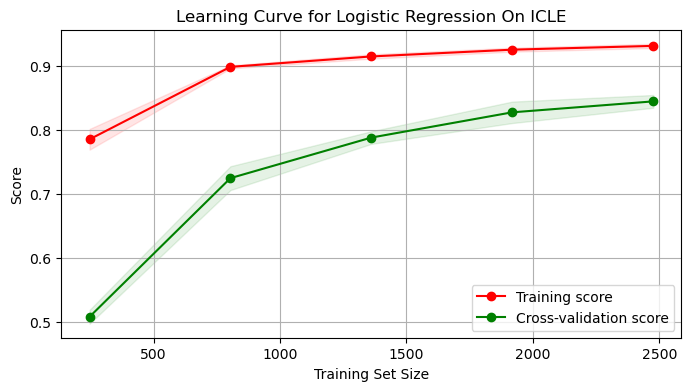

In [12]:
# Define a function to plot the learning curve
def plot_learning_curve(estimator, X, y, cv=5, scoring='accuracy', train_sizes=np.linspace(0.1, 1.0, 5)):
    train_sizes, train_scores, test_scores = learning_curve(estimator, X, y, cv=cv, scoring=scoring, train_sizes=train_sizes, n_jobs=-1)

    # Calculate mean and standard deviation for training and validation scores
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    # Plot learning curve
    plt.figure(figsize=(8, 4))
    plt.plot(train_sizes, train_scores_mean, 'o-', color='r', label='Training score')
    plt.plot(train_sizes, test_scores_mean, 'o-', color='g', label='Cross-validation score')

    # Plot the variance as a filled region
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1, color='r')
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color='g')

    plt.title('Learning Curve for Logistic Regression On ICLE')
    plt.xlabel('Training Set Size')
    plt.ylabel('Score')
    plt.legend(loc='best')
    plt.grid(True)
    plt.show()

# Call the function to plot the learning curve
plot_learning_curve(pipe, X_train_icle, y_train_icle)

### ICLE in-corpus LogReg + NLP

              precision    recall  f1-score   support

         DEU       0.77      0.89      0.82        45
         FRA       0.76      0.81      0.78        31
         ITA       0.85      0.88      0.86        40
         JPN       0.85      0.76      0.80        37
         KOR       0.83      0.88      0.85        40
         SPA       0.86      0.76      0.81        25
         TUR       0.87      0.69      0.77        29
         ZHO       0.91      0.92      0.91        98

    accuracy                           0.85       345
   macro avg       0.84      0.82      0.83       345
weighted avg       0.85      0.85      0.85       345



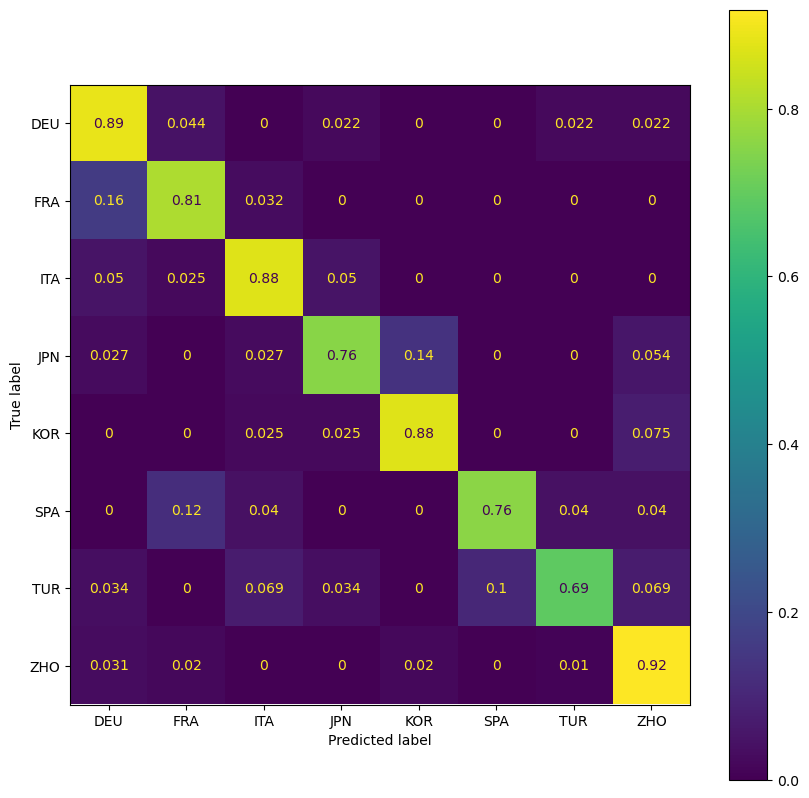

In [13]:
y_icle_pred = pipe.predict(X_test_icle)

print(classification_report(y_test_icle, y_icle_pred))

cm = confusion_matrix(y_test_icle, y_icle_pred, labels=pipe.classes_, normalize='true')
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=pipe.classes_)

fig, ax = plt.subplots(figsize=(10,10))
disp.plot(ax=ax)

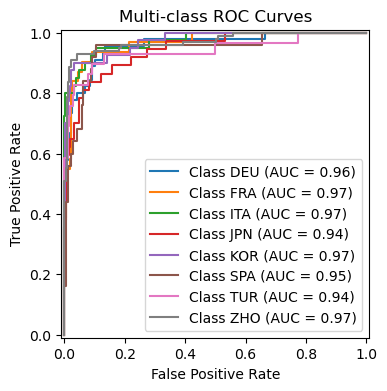

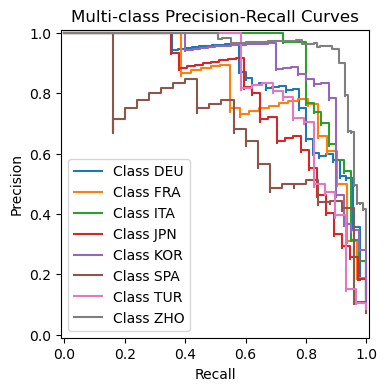

In [17]:
# Binarize the output labels for multi-class
y_train_binarized = label_binarize(y_train_icle, classes=pipe.classes_)
y_test_binarized = label_binarize(y_test_icle, classes=pipe.classes_)
n_classes = y_train_binarized.shape[1]

# Train a OneVsRestClassifier using the same pipeline setup
ovr_clf = OneVsRestClassifier(pipe)
ovr_clf.fit(X_train_icle, y_train_binarized)

# Predict probabilities for ROC and PR curves
y_score = ovr_clf.predict_proba(X_test_icle)

# Plotting ROC curves for each class
plt.figure(figsize=(8, 4))
for i in range(n_classes):
    fpr, tpr, _ = roc_curve(y_test_binarized[:, i], y_score[:, i])
    roc_auc = auc(fpr, tpr)
    RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc, estimator_name=f'Class {pipe.classes_[i]}').plot(ax=plt.gca())

plt.title('Multi-class ROC Curves')
plt.show()

# Plotting Precision-Recall curves for each class
plt.figure(figsize=(8, 4))
for i in range(n_classes):
    precision, recall, _ = precision_recall_curve(y_test_binarized[:, i], y_score[:, i])
    avg_precision = average_precision_score(y_test_binarized[:, i], y_score[:, i])
    PrecisionRecallDisplay(precision=precision, recall=recall, estimator_name=f'Class {pipe.classes_[i]}').plot(ax=plt.gca())

plt.title('Multi-class Precision-Recall Curves')
plt.show()

### TOEFL cross-corpus LogReg + NLP

              precision    recall  f1-score   support

         DEU       0.24      0.76      0.36      1100
         FRA       0.68      0.04      0.07      1100
         ITA       0.39      0.19      0.26      1100
         JPN       0.38      0.39      0.39      1100
         KOR       0.28      0.58      0.38      1100
         SPA       0.46      0.05      0.09      1100
         TUR       0.56      0.13      0.21      1100
         ZHO       0.39      0.34      0.36      1100

    accuracy                           0.31      8800
   macro avg       0.42      0.31      0.27      8800
weighted avg       0.42      0.31      0.27      8800



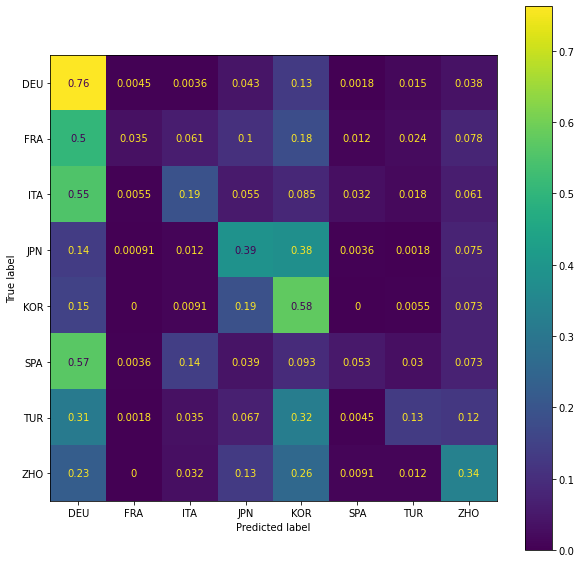

In [14]:
y_toefl_pred = pipe.predict(X_toefl)

print(classification_report(y_toefl, y_toefl_pred))

cm = confusion_matrix(y_toefl, y_toefl_pred, labels=pipe.classes_, normalize='true')
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=pipe.classes_)

fig, ax = plt.subplots(figsize=(10,10))
disp.plot(ax=ax)

## Logistic Regression + NLP - POS

In [15]:
# we will scale the numeric features
scaler = StandardScaler()

# we will use a bag of word pattern vecorizer for the text and another one for the pos tags
vect1 = TfidfVectorizer(max_features=10000, ngram_range=(1,2), lowercase=False, tokenizer= str.split)
vect2 = TfidfVectorizer(max_features=200, ngram_range=(1,4), lowercase=False, tokenizer= str.split)

# We distribute the different columns to different preprocessing steps
preprocessor = make_column_transformer(
    (scaler, ['readability_words','readability_sents']), # we scale the numeric features
    (vect1, 'text'), # uni and bigrams bag of words
#     (vect2, 'pos'), # up to 4-grams for pos patterns (fewer different patterns)
    remainder = 'drop')
clf = LogisticRegression(random_state=42, max_iter=1000)

pipe = make_pipeline(preprocessor, clf)

pipe.fit(X_train_icle, y_train_icle)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('standardscaler',
                                                  StandardScaler(),
                                                  ['readability_words',
                                                   'readability_sents']),
                                                 ('tfidfvectorizer',
                                                  TfidfVectorizer(lowercase=False,
                                                                  max_features=10000,
                                                                  ngram_range=(1,
                                                                               2),
                                                                  tokenizer=<method 'split' of 'str' objects>),
                                                  'text')])),
                ('logisticregression',
                 LogisticRegression(max_iter=1000, random_state=

### ICLE in-corpus LogReg + NLP - POS

              precision    recall  f1-score   support

         DEU       0.76      0.82      0.79        45
         FRA       0.81      0.81      0.81        31
         ITA       0.81      0.88      0.84        40
         JPN       0.82      0.76      0.79        37
         KOR       0.83      0.85      0.84        40
         SPA       0.82      0.72      0.77        25
         TUR       0.83      0.69      0.75        29
         ZHO       0.90      0.93      0.91        98

    accuracy                           0.83       345
   macro avg       0.82      0.81      0.81       345
weighted avg       0.84      0.83      0.83       345



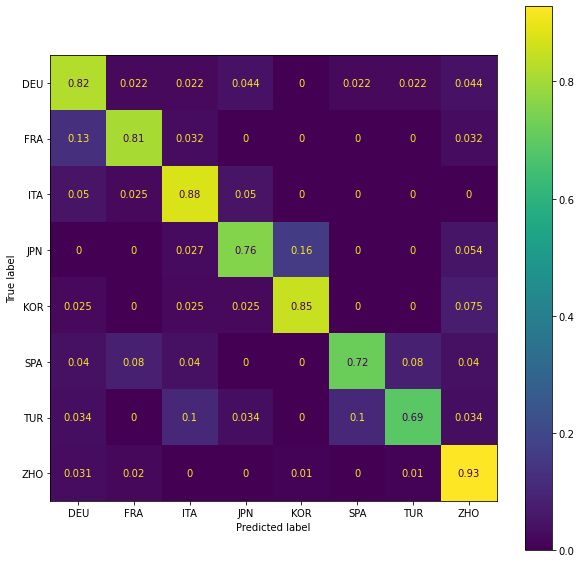

In [16]:
y_icle_pred = pipe.predict(X_test_icle)

print(classification_report(y_test_icle, y_icle_pred))

cm = confusion_matrix(y_test_icle, y_icle_pred, labels=pipe.classes_, normalize='true')
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=pipe.classes_)

fig, ax = plt.subplots(figsize=(10,10))
disp.plot(ax=ax)

### TOEFL cross-corpus LogReg + NLP - POS

              precision    recall  f1-score   support

         DEU       0.22      0.67      0.33      1100
         FRA       0.62      0.03      0.05      1100
         ITA       0.41      0.18      0.25      1100
         JPN       0.36      0.39      0.38      1100
         KOR       0.26      0.58      0.36      1100
         SPA       0.43      0.05      0.09      1100
         TUR       0.58      0.07      0.13      1100
         ZHO       0.39      0.35      0.37      1100

    accuracy                           0.29      8800
   macro avg       0.41      0.29      0.25      8800
weighted avg       0.41      0.29      0.25      8800



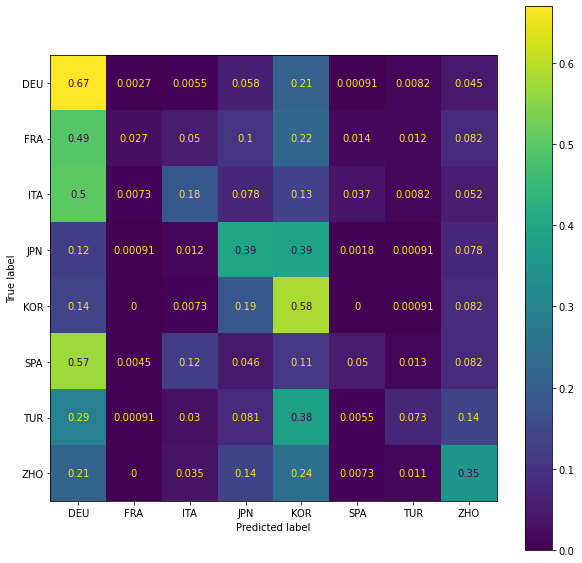

In [17]:
y_toefl_pred = pipe.predict(X_toefl)

print(classification_report(y_toefl, y_toefl_pred))

cm = confusion_matrix(y_toefl, y_toefl_pred, labels=pipe.classes_, normalize='true')
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=pipe.classes_)

fig, ax = plt.subplots(figsize=(10,10))
disp.plot(ax=ax)

## Logistic Regression + NLP - Complexity

In [18]:
# we will scale the numeric features
scaler = StandardScaler()

# we will use a bag of word pattern vecorizer for the text and another one for the pos tags
vect1 = TfidfVectorizer(max_features=10000, ngram_range=(1,2), lowercase=False, tokenizer= str.split)
vect2 = TfidfVectorizer(max_features=200, ngram_range=(1,4), lowercase=False, tokenizer= str.split)

# We distribute the different columns to different preprocessing steps
preprocessor = make_column_transformer(
#     (scaler, ['readability_words','readability_sents']), # we scale the numeric features
    (vect1, 'text'), # uni and bigrams bag of words
    (vect2, 'pos'), # up to 4-grams for pos patterns (fewer different patterns)
    remainder = 'drop')
clf = LogisticRegression(random_state=42, max_iter=1000)

pipe = make_pipeline(preprocessor, clf)

pipe.fit(X_train_icle, y_train_icle)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('tfidfvectorizer-1',
                                                  TfidfVectorizer(lowercase=False,
                                                                  max_features=10000,
                                                                  ngram_range=(1,
                                                                               2),
                                                                  tokenizer=<method 'split' of 'str' objects>),
                                                  'text'),
                                                 ('tfidfvectorizer-2',
                                                  TfidfVectorizer(lowercase=False,
                                                                  max_features=200,
                                                                  ngram_range=(1,
                                                                  

### ICLE in-corpus LogReg + NLP - Complexity

              precision    recall  f1-score   support

         DEU       0.75      0.87      0.80        45
         FRA       0.74      0.81      0.77        31
         ITA       0.90      0.88      0.89        40
         JPN       0.82      0.73      0.77        37
         KOR       0.79      0.82      0.80        40
         SPA       0.90      0.72      0.80        25
         TUR       0.85      0.76      0.80        29
         ZHO       0.91      0.92      0.91        98

    accuracy                           0.84       345
   macro avg       0.83      0.81      0.82       345
weighted avg       0.84      0.84      0.84       345



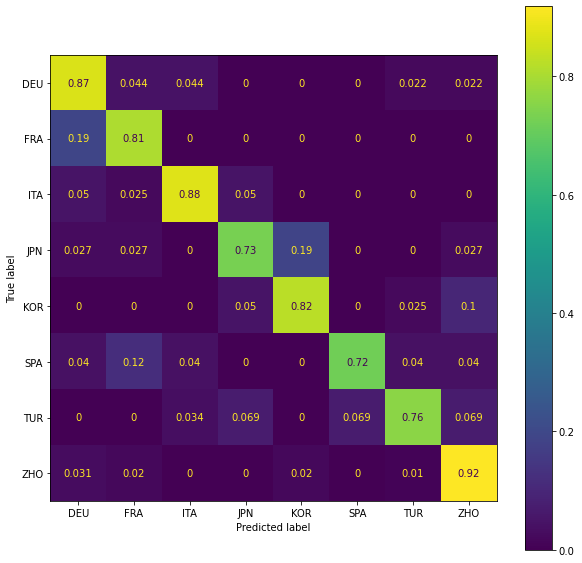

In [19]:
y_icle_pred = pipe.predict(X_test_icle)

print(classification_report(y_test_icle, y_icle_pred))

cm = confusion_matrix(y_test_icle, y_icle_pred, labels=pipe.classes_, normalize='true')
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=pipe.classes_)

fig, ax = plt.subplots(figsize=(10,10))
disp.plot(ax=ax)

### TOEFL cross-corpus LogReg + NLP - Complexity

              precision    recall  f1-score   support

         DEU       0.25      0.83      0.38      1100
         FRA       0.73      0.04      0.08      1100
         ITA       0.61      0.12      0.20      1100
         JPN       0.39      0.37      0.38      1100
         KOR       0.31      0.67      0.42      1100
         SPA       0.41      0.03      0.05      1100
         TUR       0.47      0.13      0.20      1100
         ZHO       0.37      0.35      0.36      1100

    accuracy                           0.32      8800
   macro avg       0.44      0.32      0.26      8800
weighted avg       0.44      0.32      0.26      8800



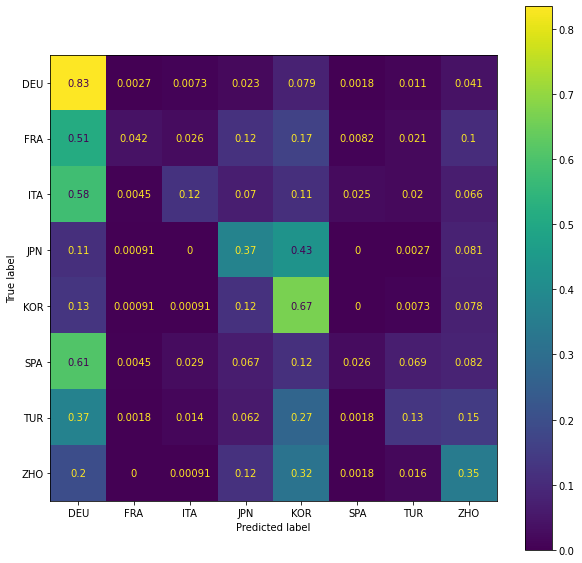

In [20]:
y_toefl_pred = pipe.predict(X_toefl)

print(classification_report(y_toefl, y_toefl_pred))

cm = confusion_matrix(y_toefl, y_toefl_pred, labels=pipe.classes_, normalize='true')
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=pipe.classes_)

fig, ax = plt.subplots(figsize=(10,10))
disp.plot(ax=ax)

## Logistic Regression - NLP

In [21]:
# we will scale the numeric features
scaler = StandardScaler()

# we will use a bag of word pattern vecorizer for the text and another one for the pos tags
vect1 = TfidfVectorizer(max_features=10000, ngram_range=(1,2), lowercase=False, tokenizer= str.split)
vect2 = TfidfVectorizer(max_features=200, ngram_range=(1,4), lowercase=False, tokenizer= str.split)

# We distribute the different columns to different preprocessing steps
preprocessor = make_column_transformer(
#     (scaler, ['readability_words','readability_sents']), 
    (vect1, 'text'), # uni and bigrams bag of words
#     (vect2, 'pos'), # up to 4-grams for pos patterns (fewer different patterns)
    remainder = 'drop')
clf = LogisticRegression(random_state=42, max_iter=1000)

pipe = make_pipeline(preprocessor, clf)

pipe.fit(X_train_icle, y_train_icle)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('tfidfvectorizer',
                                                  TfidfVectorizer(lowercase=False,
                                                                  max_features=10000,
                                                                  ngram_range=(1,
                                                                               2),
                                                                  tokenizer=<method 'split' of 'str' objects>),
                                                  'text')])),
                ('logisticregression',
                 LogisticRegression(max_iter=1000, random_state=42))])

### ICLE in-corpus LogReg - NLP 

              precision    recall  f1-score   support

         DEU       0.76      0.87      0.81        45
         FRA       0.75      0.77      0.76        31
         ITA       0.89      0.85      0.87        40
         JPN       0.85      0.78      0.82        37
         KOR       0.81      0.88      0.84        40
         SPA       0.85      0.68      0.76        25
         TUR       0.76      0.76      0.76        29
         ZHO       0.92      0.92      0.92        98

    accuracy                           0.84       345
   macro avg       0.83      0.81      0.82       345
weighted avg       0.84      0.84      0.84       345



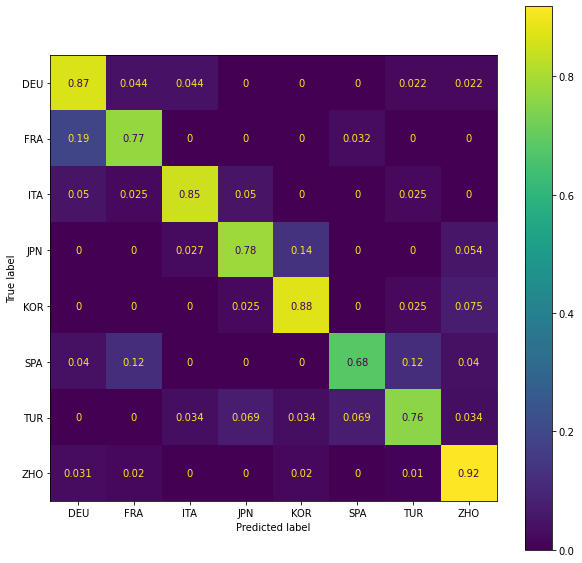

In [22]:
y_icle_pred = pipe.predict(X_test_icle)

print(classification_report(y_test_icle, y_icle_pred))

cm = confusion_matrix(y_test_icle, y_icle_pred, labels=pipe.classes_, normalize='true')
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=pipe.classes_)

fig, ax = plt.subplots(figsize=(10,10))
disp.plot(ax=ax)

### TOEFL cross-corpus LogReg - NLP

              precision    recall  f1-score   support

         DEU       0.26      0.75      0.38      1100
         FRA       0.70      0.03      0.06      1100
         ITA       0.73      0.05      0.09      1100
         JPN       0.37      0.33      0.35      1100
         KOR       0.26      0.74      0.38      1100
         SPA       0.38      0.02      0.04      1100
         TUR       0.56      0.08      0.14      1100
         ZHO       0.39      0.39      0.39      1100

    accuracy                           0.30      8800
   macro avg       0.46      0.30      0.23      8800
weighted avg       0.46      0.30      0.23      8800



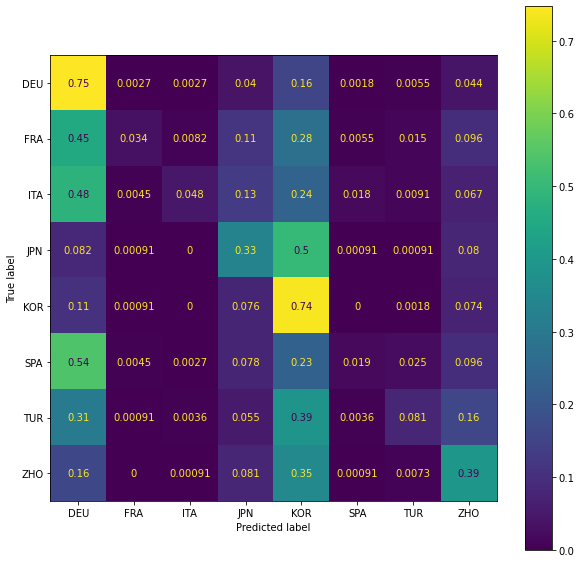

In [23]:
y_toefl_pred = pipe.predict(X_toefl)

print(classification_report(y_toefl, y_toefl_pred))

cm = confusion_matrix(y_toefl, y_toefl_pred, labels=pipe.classes_, normalize='true')
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=pipe.classes_)

fig, ax = plt.subplots(figsize=(10,10))
disp.plot(ax=ax)